# 0.0. Imports

In [11]:
import json
import numpy      as np
import pandas     as pd
import pickle
import xgboost    as xgb
import seaborn    as sns
import scikitplot as skplt

from xgboost               import XGBClassifier
from sklearn               import preprocessing as pp
from sklearn               import model_selection as ms
from sklearn               import ensemble as en
from sklearn               import neighbors as nh
from sklearn               import linear_model as lm
from matplotlib            import pyplot as plt
from sklearn.ensemble      import RandomForestClassifier
from sklearn.ensemble      import ExtraTreesClassifier

## 0.1. Loading Data

In [12]:
df_raw = pd.read_csv( '/Users/thiago/Thiago/Data_Science/comunidade_ds/health_insurance/data/raw/train.csv' )

In [13]:
df_raw.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


## 0.2. Helper Functions

In [72]:
sns.set(rc={'figure.figsize':(17,10)}) # Aumenta o tamanho dos plots no seaborn

def precision_at_k( data, yhat_proba, perc ):

    k = int(np.floor( len( data ) * perc ) )
    data['score'] = yhat_proba[:,1].tolist()
    data = data.sort_values( 'score', ascending=False )
    data = data.reset_index( drop=True )
    data['ranking'] = data.index+1
    data['precision_at_k'] = data['response'].cumsum() / data['ranking']
    
    # # reset index
    # data = data.reset_index( drop=True )
    # # create ranking order
    # data['ranking'] = data.index + 1
    # data['precision_at_k'] = data['response'].cumsum() / data['ranking']
    # return data.loc[k, 'precision_at_k']

    return data.loc[k,'precision_at_k']


def recall_at_k( data, yhat_proba, perc ):

    k = int(np.floor( len( data ) * perc ) )
    data['score'] = yhat_proba[:,1].tolist()
    data = data.sort_values( 'score', ascending=False )
    data = data.reset_index( drop=True )
    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()

    # reset index
    # data = data.reset_index( drop=True )
    # # create ranking order
    # data['ranking'] = data.index + 1
    # data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()
    # return data.loc[k, 'recall_at_k']

    return data.loc[k, 'recall_at_k' ]


In [129]:
def cross_validation( models_performance, num_folds, modelName, model, x_train, y_train ):
    kfold=ms.StratifiedKFold( n_splits = num_folds, shuffle=True, random_state=42 )

    precision_list = []
    recall_list = []
    f1_list = []
    roc_list = []

    i = 1
    for train_cv, val_cv in kfold.split( x_train, y_train ):

        x_train_fold = x_train.iloc[train_cv]
        y_train_fold = y_train.iloc[train_cv]

        x_val_fold = x_train.iloc[val_cv]
        y_val_fold = y_train.iloc[val_cv]

        model_fit = model.fit( x_train_fold, y_train_fold )

        yhat_model = model_fit.predict_proba( x_val_fold )

        x_val_fold['response'] = y_val_fold
        precision = round(precision_at_k( x_val_fold, yhat_model, 0.20 ), 3 )
        recall = round( recall_at_k( x_val_fold, yhat_model, 0.20), 3 )
        
        precision_list.append( precision )
        recall_list.append( recall )

        i += 1

        precision_str = np.round( np.mean( precision_list ), 4).astype(str) + '+/-' + np.round( np.std( precision_list ), 4).astype(str)
        recall_str = np.round( np.mean( recall_list ), 4).astype(str) + '+/-' + np.round( np.std( recall_list), 4).astype(str)

        models_performance = models_performance.append(pd.Series( [ modelName, precision_str, recall_str ], index=models_performance.columns ), ignore_index = True )

        return models_performance

# 1.0. DATA DESCRIPTION

In [16]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [17]:
df1.columns

Index(['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object')

In [18]:
 cols_new = ['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response']

df1.columns = cols_new

In [19]:
df1.columns

Index(['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response'],
      dtype='object')

## 1.2. Data Dimensions

In [20]:
print( 'Number of rows:{}'.format( df1.shape[0]))
print( 'Number of columns:{}'.format( df1.shape[1]))

Number of rows:381109
Number of columns:12


## 1.3. Data Types

In [21]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 1.4. Check NA

In [22]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 1.5. Descriptive Statistical

In [23]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( include=['int64', 'float64', 'datetime64[ns]'] )

In [24]:
# Central Tendency - Mean, Meadian
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# Concat
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = [ 'attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,9.443274e-16,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
3,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
4,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
5,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
6,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
7,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
8,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788


# 2.0. FEATURE ENGINEERING

In [25]:
df2 = df1.copy()

In [26]:
# vehicle age
df2['vehicle_age'] = df2['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' 
                                                                        if x == '1-2 Year' else 'below_1_year' )
# vehicle damage                                                                     
df2['vehicle_damage'] = df2['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 )

In [27]:
df2.head(10)

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,1,28.0,0,over_2_years,1,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,between_1_2_year,0,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,over_2_years,1,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,below_1_year,0,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,below_1_year,0,27496.0,152.0,39,0
5,6,Female,24,1,33.0,0,below_1_year,1,2630.0,160.0,176,0
6,7,Male,23,1,11.0,0,below_1_year,1,23367.0,152.0,249,0
7,8,Female,56,1,28.0,0,between_1_2_year,1,32031.0,26.0,72,1
8,9,Female,24,1,3.0,1,below_1_year,0,27619.0,152.0,28,0
9,10,Female,32,1,6.0,1,below_1_year,0,28771.0,152.0,80,0


# 3.0. FILTERING

In [28]:
df3 = df2.copy()

Como não detectamos variáveis muito fora dos possíveis padrões, não será inicialmente realizar uma filtragem
de variáveis.

# 4.0. EDA

In [29]:
df4 = df3.copy()

## 4.1. Univariate Analisys

In [30]:
df4.columns

Index(['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response'],
      dtype='object')

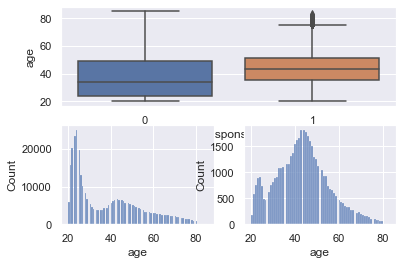

In [31]:
#age
plt.subplot( 2, 1, 1)
sns.boxplot( x='response', y='age', data=df4)

plt.subplot( 2, 2, 3)
aux00 = df4.loc[df4['response'] == 0, 'age']
sns.histplot( aux00 )

plt.subplot( 2, 2, 4)
aux00 = df4.loc[df4['response'] == 1, 'age']
sns.histplot( aux00 );

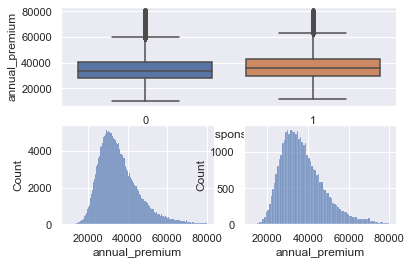

In [32]:
#annual_premium
aux0 = df4[ ( df4['annual_premium'] > 10000 ) & ( df4['annual_premium'] < 80000 ) ]
plt.subplot( 2, 1, 1)
sns.boxplot( x='response', y='annual_premium', data=aux0)

plt.subplot( 2, 2, 3)
aux1 = aux0.loc[aux0['response'] == 0, 'annual_premium']
sns.histplot( aux1 )

plt.subplot( 2, 2, 4)
aux2= aux0.loc[aux0['response'] == 1, 'annual_premium']
sns.histplot( aux2 );

In [33]:
#driving_license
aux = df4[['driving_license', 'response']].groupby( 'response' ).sum().reset_index()
aux.head()
aux['driving_license'] = aux['driving_license'] / aux['driving_license'].sum()
#sns.barplot( x='response', y='driving_license', data=aux);

In [34]:
aux

,response,driving_license
0,0,0.877283
1,1,0.122717


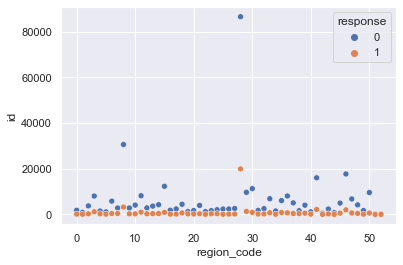

In [35]:
#region_code
aux = df4[['id', 'region_code', 'response']].groupby( ['region_code', 'response'] ).count().reset_index()
sns.scatterplot( x='region_code', y='id', hue='response', data=aux);

In [36]:
#gender

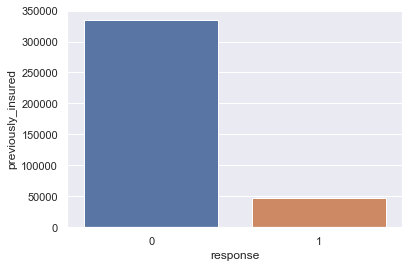

In [37]:
#previously_insured
aux = df4[['previously_insured', 'response']].groupby( 'response' ).count().reset_index()
aux
sns.barplot( x='response', y='previously_insured', data=aux);

In [38]:
pd.crosstab( df4['previously_insured'], df4['response'] )

response,0,1
previously_insured,,
0,159929,46552
1,174470,158


In [39]:
pd.crosstab( df4['previously_insured'], df4['response'] ).apply( lambda x: x / x.sum(), axis=1)

response,0,1
previously_insured,,
0,0.774546,0.225454
1,0.999095,0.000905


In [40]:
#vehicle_age
df4[['vehicle_age' ,'response']].value_counts( normalize=True ).reset_index()

,vehicle_age,response,0
0,between_1_2_year,0,0.434285
1,below_1_year,0,0.413488
2,between_1_2_year,1,0.091328
3,over_2_years,0,0.029663
4,below_1_year,1,0.018897
5,over_2_years,1,0.012338


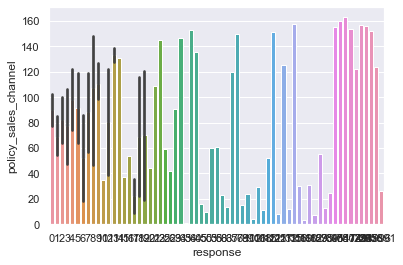

In [41]:
#policy_sales_channel
aux = df4[['policy_sales_channel', 'response']].groupby( 'policy_sales_channel').sum().reset_index()
sns.barplot( x='response', y='policy_sales_channel', data=aux); 

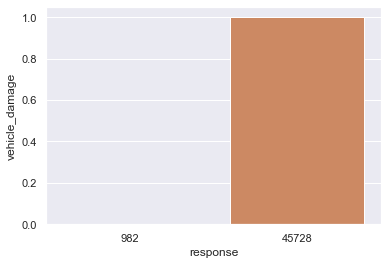

In [42]:
#vehicle_damage
aux = df4[['vehicle_damage', 'response']].groupby( 'vehicle_damage').sum().reset_index()
sns.barplot( x='response', y='vehicle_damage', data=aux); 

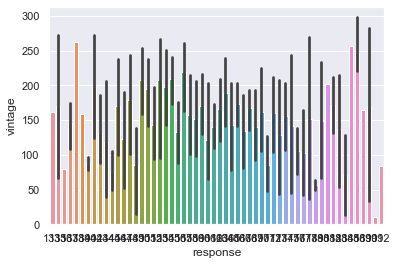

In [43]:
#vintage
aux = df4[['vintage', 'response']].groupby( 'vintage').sum().reset_index()
sns.barplot( x='response', y='vintage', data=aux); 

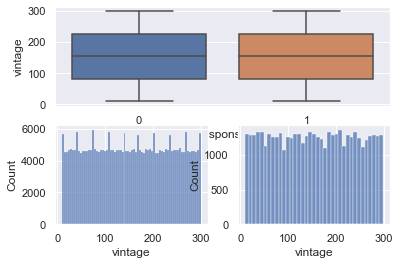

In [44]:
plt.subplot( 2, 1, 1)
sns.boxplot( x='response', y='vintage', data=df4)

plt.subplot( 2, 2, 3)
aux1 = df4.loc[df4['response'] == 0, 'vintage']
sns.histplot( aux1 )

plt.subplot( 2, 2, 4)
aux2= df4.loc[df4['response'] == 1, 'vintage']
sns.histplot( aux2 );

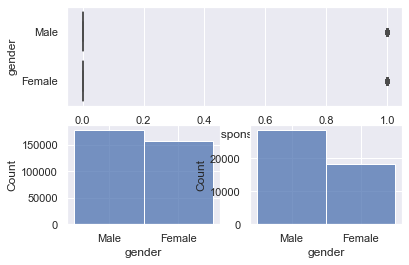

In [45]:
#gender
plt.subplot( 2, 1, 1)
sns.boxplot( x='response', y='gender', data=df4)

plt.subplot( 2, 2, 3)
aux1 = df4.loc[df4['response'] == 0, 'gender']
sns.histplot( aux1 )

plt.subplot( 2, 2, 4)
aux2= df4.loc[df4['response'] == 1, 'gender']
sns.histplot( aux2 );

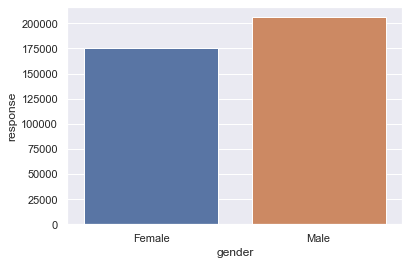

In [46]:
aux = df4[['gender', 'response']].groupby('gender').count().reset_index()
sns.barplot( x='gender', y='response', data=aux); 

# 5.0. DATA PREPARATION

In [47]:
df5 = df4.copy()

### Data  Split Train / Teste

In [48]:
X = df4.drop( 'response', axis=1 )
y = df4['response'].copy()

x_train, x_validation, y_train, y_validation = ms.train_test_split( X, y, test_size=0.20 )

df5 = pd.concat( [x_train, y_train], axis=1 )

## 5.1. Standardization

In [49]:
ss = pp.StandardScaler()

# annual_premium|
df5['annual_premium'] = ss.fit_transform( df5[['annual_premium']].values ) # dois colchetes pois é necessário um array para o correto funciomanento dos Encoders
pickle.dump( ss, open( '/Users/thiago/Thiago/Data_Science/comunidade_ds/health_insurance/src/features/annual_premium_scaler.pkl', 'wb' ) )

## 5.2. Rescaling

In [50]:
mms_age = pp.MinMaxScaler()
mms_vintage= pp.MinMaxScaler()

# age
df5['age'] = mms_age.fit_transform( df5[['age']].values )
pickle.dump( mms_age, open( '/Users/thiago/Thiago/Data_Science/comunidade_ds/health_insurance/src/features/age_scaler.pkl', 'wb' ) )

# vintage
df5['vintage'] = mms_vintage.fit_transform( df5[['vintage']].values )
pickle.dump( mms_vintage, open( '/Users/thiago/Thiago/Data_Science/comunidade_ds/health_insurance/src/features/vintage_scaler.pkl', 'wb' ) )

## 5.3. Transformation

## 5.3.1 Encoding

In [51]:
df5['region_code'].unique() # alto número de variáveis, não recomendado usar o One Hot Encoding, pois vai complicar demais e requer uma quantidade maior de dados

array([30., 33., 50., 46., 41., 10., 28.,  6., 11., 47.,  1., 13., 35.,
       37., 25.,  8., 15., 39.,  7., 14., 24.,  0., 29., 45., 18., 36.,
       27.,  9., 21., 12., 19., 23.,  3.,  2., 31., 32., 48., 49.,  5.,
       16., 34., 43., 17., 20., 42., 44., 38., 51., 22., 26., 40.,  4.,
       52.])

In [52]:
# driving_license / vehicle_damage / driving_license - Ja estão 0 e 1 ( Label Encoding )

# gender
target_encode_gender = df5.groupby( 'gender' )['response'].mean()
df5.loc[:, 'gender'] = df5['gender'].map( target_encode_gender )
pickle.dump( target_encode_gender, open( '/Users/thiago/Thiago/Data_Science/comunidade_ds/health_insurance/src/features/target_encode_gender_scaler.pkl', 'wb' ) )

# region_code - Frequency Encoding / Target Encoding / Weight Target Encoding
target_encode_region_code = df5.groupby( 'region_code' )['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map( target_encode_region_code )
pickle.dump( target_encode_region_code, open( '/Users/thiago/Thiago/Data_Science/comunidade_ds/health_insurance/src/features/target_encode_region_code_scaler.pkl', 'wb' ) )

# vehicle_age - One Hot Encoding / Order Encoding / Frequency Encoding
df5 = pd.get_dummies( df5, prefix='vehicle_age', columns=['vehicle_age'] )

# policy_sales_channel - Target Encoding / Frequency Encoding
fe_policy_sales_channel = df5.groupby( 'policy_sales_channel' ).size() / len( df5 )
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map( fe_policy_sales_channel )
pickle.dump( fe_policy_sales_channel, open( '/Users/thiago/Thiago/Data_Science/comunidade_ds/health_insurance/src/features/fe_policy_sales_channel_scaler.pkl', 'wb' ) )

## 5.4 Validation Preparation

In [53]:
x_validation.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage
348444,348445,Male,24,1,28.0,0,below_1_year,1,29692.0,124.0,74
236400,236401,Male,55,1,28.0,0,over_2_years,1,28374.0,26.0,111
186920,186921,Male,43,1,46.0,0,between_1_2_year,1,22053.0,156.0,274
47701,47702,Male,42,1,4.0,1,between_1_2_year,1,2630.0,157.0,223
366415,366416,Male,61,1,1.0,1,between_1_2_year,0,2630.0,26.0,106


In [54]:
# gender
x_validation.loc[:, 'gender'] = x_validation.loc[:, 'gender'].map( target_encode_gender )

# age
x_validation.loc[:, 'age'] = mms_age.transform( x_validation[['age']].values )

# region code
x_validation.loc[:, 'region_code'] = x_validation.loc[:, 'region_code'].map( target_encode_region_code )

# vehicle age
x_validation = pd.get_dummies( x_validation, prefix='vehicle_age', columns=['vehicle_age'] )

# annual premium
x_validation.loc[:, 'annual_premium'] = ss.transform( x_validation[['annual_premium']].values )

# policy sales channel
x_validation.loc[:, 'policy_sales_channel'] = x_validation['policy_sales_channel'].map( fe_policy_sales_channel )

# vintage
x_validation.loc[:, 'vintage'] = mms_vintage.transform( x_validation[['vintage']].values )

# fillna
x_validation = x_validation.fillna( 0 )

# 6.0. FEATURE SELECTION

## 6.2 Features Importance

In [55]:
# model definition
forest = en.ExtraTreesClassifier( n_estimators=250, random_state=0, n_jobs=-1 )

# data preaparation
x_train_n = df5.drop( ['id', 'response'], axis=1 )
y_train_n = y_train.values
forest.fit( x_train_n, y_train_n )

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature ranking:
                        feature  importance
0                       vintage    0.271580
0                annual_premium    0.244079
0                           age    0.166739
0                   region_code    0.105395
0                vehicle_damage    0.067853
0          policy_sales_channel    0.060306
0            previously_insured    0.056906
0      vehicle_age_below_1_year    0.013336
0  vehicle_age_between_1_2_year    0.006356
0                        gender    0.004685
0      vehicle_age_over_2_years    0.002267
0               driving_license    0.000500


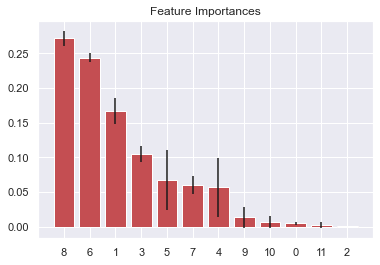

In [56]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0 )
indices = np.argsort(importances)[::-1]

# Print the Feature Ranking
print("Feature ranking:")
df = pd.DataFrame()
for i, j in zip( x_train_n, forest.feature_importances_ ):
    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0] )
    df = pd.concat( [ df, aux], axis=0 )

print( df.sort_values( 'importance', ascending=False ) )

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title( "Feature Importances" )
plt.bar(range(x_train_n.shape[1]), importances[indices], color="r", yerr=std[indices], align="center" )
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()

# 7.0. MACHINE LEARNING MODELLING

In [57]:
cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured', 'policy_sales_channel']

x_train = df5[ cols_selected ]
x_val = x_validation[ cols_selected ]
y_val = y_validation.copy()

## 7.1. KNN

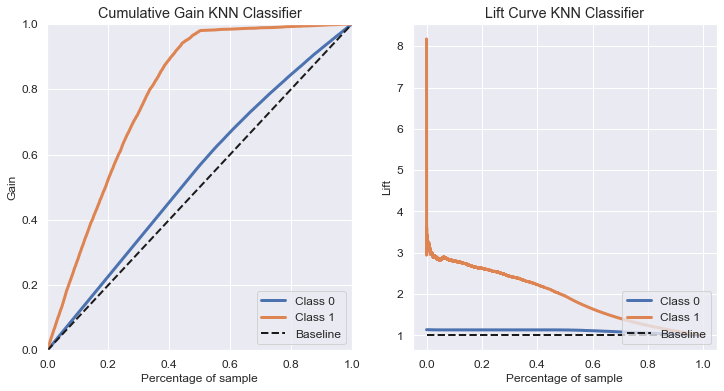

In [137]:
# model definition
knn_model = nh.KNeighborsClassifier( n_neighbors=20 )

# model training
knn_model.fit( x_train, y_train )

# model prediction - Generalization Power
yhat_knn = knn_model.predict_proba( x_val )

fig, axs = plt.subplots( ncols=2, figsize= (12,6) )
# Acummulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_knn, ax=axs[0], title='Cumulative Gain KNN Classifier');
# Scikitplot library
skplt.metrics.plot_lift_curve( y_val, yhat_knn, ax=axs[1], title='Lift Curve KNN Classifier' );

In [138]:
x_validation['response'] = y_validation
precision_knn = round( precision_at_k( x_validation, yhat_knn, 0.20), 3)
recall_knn = round( recall_at_k( x_validation, yhat_knn, 0.20), 3)

print( "Precision at k: {}".format( precision_knn ) )
print( "Recall at k: {}".format( recall_knn ) )

Precision at k: 0.32
Recall at k: 0.523


In [148]:
models_performance = models_performance.append( pd.Series( [ 'KNN Classifier', precision_knn, recall_knn], index=models_performance.columns ), ignore_index = True )
models_performance

/var/folders/w5/0w2xv4r95g1gfgbzpp2dm6gr0000gn/T/ipykernel_1400/3863666871.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  models_performance = models_performance.append( pd.Series( [ 'KNN Classifier', precision_knn, recall_knn], index=models_performance.columns ), ignore_index = True )


,Model,Precision_at_k,Recall_at_k
0,KNN Classifier,0.32,0.523


## 7.2. Logistic Regression

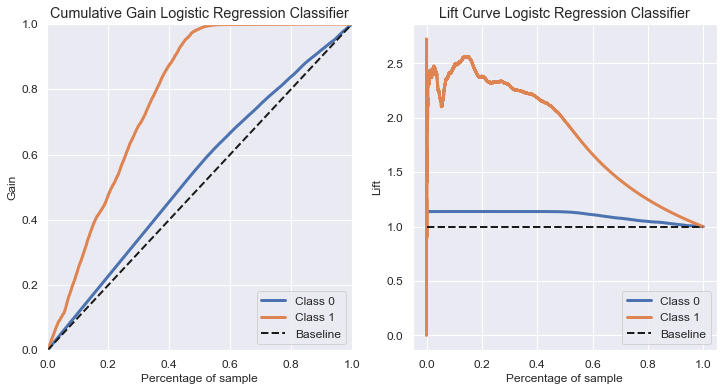

In [149]:
# model definition
lr_model = lm.LogisticRegression( random_state=42 )

# model training
lr_model.fit( x_train, y_train )

# model_prediction
yhat_lr = lr_model.predict_proba( x_val )


fig, axs = plt.subplots( ncols=2, figsize= (12,6) )
# Acummulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_lr, ax=axs[0], title='Cumulative Gain Logistic Regression Classifier');
# Scikitplot library
skplt.metrics.plot_lift_curve( y_val, yhat_lr, ax=axs[1], title='Lift Curve Logistc Regression Classifier' );

In [150]:
x_validation['response'] = y_validation
precision_lr = round( precision_at_k( x_validation, yhat_lr, 0.20), 3)
recall_lr = round( recall_at_k( x_validation, yhat_lr, 0.20), 3)

print( "Precision at k: {}".format( precision_lr ) )
print( "Recall at k: {}".format( recall_lr ) )

Precision at k: 0.291
Recall at k: 0.476


In [151]:
models_performance = models_performance.append( pd.Series( [ 'Logistic Regressor Classifier', precision_lr, recall_lr], index=models_performance.columns ), ignore_index = True )
models_performance

/var/folders/w5/0w2xv4r95g1gfgbzpp2dm6gr0000gn/T/ipykernel_1400/134888425.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  models_performance = models_performance.append( pd.Series( [ 'Logistic Regressor Classifier', precision_lr, recall_lr], index=models_performance.columns ), ignore_index = True )


,Model,Precision_at_k,Recall_at_k
0,KNN Classifier,0.320,0.523
1,Logistic Regressor Classifier,0.291,0.476


## 7.3. Random Forest Classifier

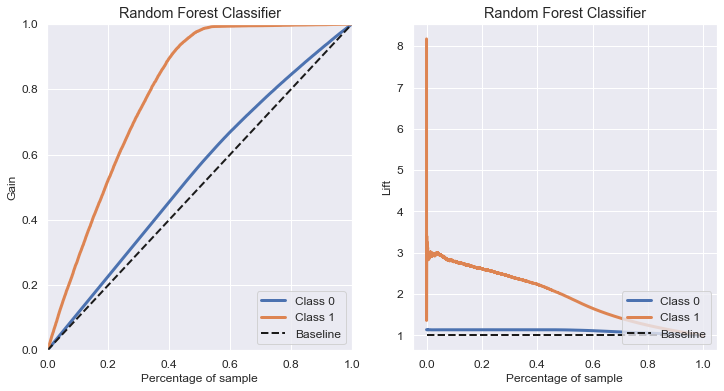

In [153]:
# model
rf_model = RandomForestClassifier( n_estimators=100, n_jobs=-1, random_state=42 ).fit( x_train, y_train )

# model training
rf_model.fit( x_train, y_train )

# model_prediction
yhat_rf = rf_model.predict_proba( x_val )

fig, axs = plt.subplots( ncols=2, figsize= (12,6) )
# Acummulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_rf, ax=axs[0], title='Random Forest Classifier');
# Scikitplot library
skplt.metrics.plot_lift_curve( y_val, yhat_rf, ax=axs[1], title='Random Forest Classifier' );

In [154]:
x_validation['response'] = y_validation
precision_rf = round( precision_at_k( x_validation, yhat_rf, 0.20), 3)
recall_rf = round( recall_at_k( x_validation, yhat_rf, 0.20), 3)

print( "Precision at k: {}".format( precision_rf ) )
print( "Recall at k: {}".format( recall_rf ) )

Precision at k: 0.319
Recall at k: 0.522


In [155]:
models_performance = models_performance.append( pd.Series( [ 'Random Forest Classifier', precision_rf, recall_rf], index=models_performance.columns ), ignore_index = True )
models_performance

/var/folders/w5/0w2xv4r95g1gfgbzpp2dm6gr0000gn/T/ipykernel_1400/349241368.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  models_performance = models_performance.append( pd.Series( [ 'Random Forest Classifier', precision_rf, recall_rf], index=models_performance.columns ), ignore_index = True )


,Model,Precision_at_k,Recall_at_k
0,KNN Classifier,0.320,0.523
1,Logistic Regressor Classifier,0.291,0.476
2,Random Forest Classifier,0.319,0.522


## 7.4. XGBoost Classifier

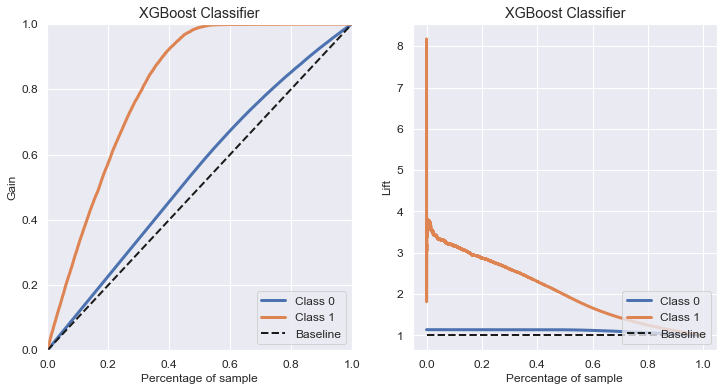

In [156]:
# model
xgb_model = XGBClassifier( max_depth= 4, n_estimators=100 ).fit( x_train, y_train )

# model training
xgb_model.fit( x_train, y_train )

# model_prediction
yhat_xgb = xgb_model.predict_proba( x_val )

fig, axs = plt.subplots( ncols=2, figsize= (12,6) )
# Acummulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_xgb, ax=axs[0], title='XGBoost Classifier');
# Scikitplot library
skplt.metrics.plot_lift_curve( y_val, yhat_xgb, ax=axs[1], title='XGBoost Classifier' );


In [157]:
x_validation['response'] = y_validation
precision_xgb = round( precision_at_k( x_validation, yhat_xgb, 0.20), 3)
recall_xgb = round( recall_at_k( x_validation, yhat_xgb, 0.20), 3)

print( "Precision at k: {}".format( precision_xgb ) )
print( "Recall at k: {}".format( recall_xgb ) )

Precision at k: 0.352
Recall at k: 0.575


In [159]:
models_performance = models_performance.append( pd.Series( [ 'XGBoost Classifier', precision_xgb, recall_xgb ], index=models_performance.columns ), ignore_index = True )
models_performance

/var/folders/w5/0w2xv4r95g1gfgbzpp2dm6gr0000gn/T/ipykernel_1400/57054842.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  models_performance = models_performance.append( pd.Series( [ 'XGBoost Classifier', precision_xgb, recall_xgb ], index=models_performance.columns ), ignore_index = True )


,Model,Precision_at_k,Recall_at_k
0,KNN Classifier,0.320,0.523
1,Logistic Regressor Classifier,0.291,0.476
2,Random Forest Classifier,0.319,0.522
3,XGBoost Classifier,0.352,0.575


## 7.5. Extra Trees

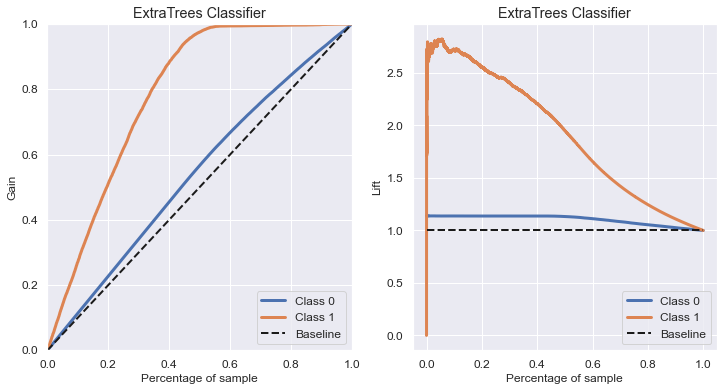

In [160]:
# model definition
et_model = ExtraTreesClassifier( n_estimators=1000, n_jobs=-1, random_state=42 )

# model fit
et_model.fit( x_train, y_train )

# model predict
yhat_et = et_model.predict_proba( x_val )

fig, axs = plt.subplots( ncols=2, figsize= (12,6) )
# Acummulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_et, ax=axs[0], title='ExtraTrees Classifier');
# Scikitplot library
skplt.metrics.plot_lift_curve( y_val, yhat_et, ax=axs[1], title='ExtraTrees Classifier' );

In [161]:
x_validation['response'] = y_validation
precision_et = round( precision_at_k( x_validation, yhat_et, 0.20), 3)
recall_et = round( recall_at_k( x_validation, yhat_et, 0.20), 3)

print( "Precision at k: {}".format( precision_et ) )
print( "Recall at k: {}".format( recall_et ) )

Precision at k: 0.313
Recall at k: 0.511


In [162]:
models_performance = models_performance.append( pd.Series( [ 'ExtraTrees Classifier', precision_et, recall_et ], index=models_performance.columns ), ignore_index = True )
models_performance

/var/folders/w5/0w2xv4r95g1gfgbzpp2dm6gr0000gn/T/ipykernel_1400/3524547721.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  models_performance = models_performance.append( pd.Series( [ 'ExtraTrees Classifier', precision_et, recall_et ], index=models_performance.columns ), ignore_index = True )


,Model,Precision_at_k,Recall_at_k
0,KNN Classifier,0.320,0.523
1,Logistic Regressor Classifier,0.291,0.476
2,Random Forest Classifier,0.319,0.522
3,XGBoost Classifier,0.352,0.575
4,ExtraTrees Classifier,0.313,0.511


# 8.0. MODEL PERFORMANCE

### 8.1. Single Performance

In [147]:
models_performance = pd.DataFrame( { 'Model':[], "Precision_at_k":[], "Recall_at_k":[] } )

models_performance

,Model,Precision_at_k,Recall_at_k


In [163]:
models_performance

,Model,Precision_at_k,Recall_at_k
0,KNN Classifier,0.320,0.523
1,Logistic Regressor Classifier,0.291,0.476
2,Random Forest Classifier,0.319,0.522
3,XGBoost Classifier,0.352,0.575
4,ExtraTrees Classifier,0.313,0.511


### 8.1. Real Performance Cross Validation

In [144]:
models_performance_cv = pd.DataFrame( { 'Model':[], "Precision_at_k":[], "Recall_at_k":[] } )

models_performance_cv

,Model,Precision_at_k,Recall_at_k


In [164]:
#cross_validation( models_performance, num_folds, modelName, model, x_train, y_train ):
models_performance_cv = cross_validation( models_performance_cv, 5, "KNN Model CV", knn_model, x_train, y_train );
models_performance_cv = cross_validation( models_performance_cv, 5, "Logistic Regressor Classifier CV", lr_model, x_train, y_train );
models_performance_cv = cross_validation( models_performance_cv, 5, "Random Forest Classifier CV", rf_model, x_train, y_train );
models_performance_cv = cross_validation( models_performance_cv, 5, "XGBoost Classifier CV", xgb_model, x_train, y_train );
models_performance_cv = cross_validation( models_performance_cv, 5, "ExtraTrees Classifier CV", et_model, x_train, y_train );


models_performance_cv



/var/folders/w5/0w2xv4r95g1gfgbzpp2dm6gr0000gn/T/ipykernel_1400/3668126845.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_val_fold['response'] = y_val_fold
/var/folders/w5/0w2xv4r95g1gfgbzpp2dm6gr0000gn/T/ipykernel_1400/1348542041.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['score'] = yhat_proba[:,1].tolist()
/var/folders/w5/0w2xv4r95g1gfgbzpp2dm6gr0000gn/T/ipykernel_1400/1348542041.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

,Model,Precision_at_k,Recall_at_k
0,KNN Model CV,0.318+/-0.0,0.519+/-0.0
1,KNN Model CV,0.318+/-0.0,0.519+/-0.0
2,Logistic Regressor Classifier CV,0.293+/-0.0,0.478+/-0.0
3,Random Forest Classifier CV,0.32+/-0.0,0.522+/-0.0
4,XGBoost Classifier CV,0.353+/-0.0,0.576+/-0.0
5,ExtraTrees Classifier CV,0.312+/-0.0,0.508+/-0.0


# 9.0. DEPLOY TO PRODUCTION

In [168]:
# Save Trained Model
#pickle.dump( lr_model, open( '/Users/thiago/Thiago/Data_Science/comunidade_ds/health_insurance/src/models/model_linear_regression.pkl', 'wb' ) )
#pickle.dump( knn_model, open( '/Users/thiago/Thiago/Data_Science/comunidade_ds/health_insurance/models/model_knn.pkl', 'wb' ) )
#pickle.dump( xgb_model, open( '/Users/thiago/Thiago/Data_Science/comunidade_ds/health_insurance/models/model_xgb.pkl', 'wb' ) )
#pickle.dump( et_model, open( '/Users/thiago/Thiago/Data_Science/comunidade_ds/health_insurance/models/model_et.pkl', 'wb' ) )

## 9.1. Health Insurance Class

In [ ]:
class HealthInsurance:

    def __init__( self ):
        self.home_path = '/Users/thiago/Thiago/Data_Science/comunidade_ds/health_insurance'
        self.annual_premium_scaler =            pickle.load( open( self.home_path + 'src/features/annual_premium_scaler.pkl', 'rb' ) ) 
        self.age_scaler =                       pickle.load( open( self.home_path + 'src/features/age_scaler.pkl', 'rb' ) ) 
        self.vintage_scaler =                   pickle.load( open( self.home_path + 'src/features/vintage_scaler.pkl', 'rb' ) ) 
        self.target_encode_gender_scaler =      pickle.load( open( self.home_path + 'src/features/target_encode_gender_scaler.pkl', 'rb' ) ) 
        self.target_encode_region_code_scaler = pickle.load( open( self.home_path + 'src/features/target_encode_region_code_scaler.pkl', 'rb' ) ) 
        self.fe_policy_sales_channel_scaler =   pickle.load( open( self.home_path + 'src/features/fe_policy_sales_channel_scaler.pkl', 'rb' ) ) 

    def data_cleaning( self, df1 ):
                
        ## 1.1. Rename Columns
        cols_new = ['id', 'gender', 'age', 'driving_license', 'region_code',
            'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
            'policy_sales_channel', 'vintage', 'response']
        # rename
        df1.columns = cols_new
        
        return df1
   
    def feature_engineering( df2 ):
                
        # vehicle age
        df2['vehicle_age'] = df2['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' 
                                                                                if x == '1-2 Year' else 'below_1_year' )
        # vehicle damage                                                                     
        df2['vehicle_damage'] = df2['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 )        

        return df2


    def data_preparation( df5 ):

        # annual_premium - StandardScaler
        df5['annual_premium'] = self.annual_premium_scaler.transform( df5[['annual_premium']].values ) 

        # age - MinMaxScaler
        df5['age'] = self.age_scaler.transform( df5[['age']].values )

        # vintage
        df5['vintage'] = self.vintage_scaler.transform( df5[['vintage']].values )

        # gender
        df5.loc[:, 'gender'] = df5['gender'].map( self.target_encode_gender_scaler )

        # region_code - Frequency Encoding / Target Encoding / Weight Target Encoding
        df5.loc[:, 'region_code'] = df5['region_code'].map( self.target_encode_region_code_scaler )

        # vehicle_age - One Hot Encoding / Order Encoding / Frequency Encoding
        df5 = pd.get_dummies( df5, prefix='vehicle_age', columns=['vehicle_age'] )

        # policy_sales_channel - Target Encoding / Frequency Encoding
        df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map( self.fe_policy_sales_channel_scaler )

        # Feature Selection
        cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured', 'policy_sales_channel']

        return df5[ cols_selected ]


    def get_prediction( self, model, original_data, test_data ):
        # model prediction
        pred = model.predict_proba( test_data )

        # join prediction into original data
        original_data['score'] = pred[:, 1].tolist()

        return original_data.to_json( orient='records', data_format='iso' )

## 9.2. API Handler

In [ ]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from healthinsurance import HealthInsurance

# loading model
path = '/Users/thiago/Thiago/Data_Science/comunidade_ds/health_insurance/'
model = pickle.load( open( path + 'src/models/model_health_insurance.pkl', 'rb' ) )

# initialize API
app = Flask( __name__ )

@app.route( '/predict', methods=['POST'] )
def health_insurance_predict():
    test_json = request.get_json()

    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
        
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
        
        # Instantiate  Rossman class
        pipeline = HealthInsurance()

        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )

        # feature enginneering
        df2 = pipeline.feature_engineering( df1 )

        # data preparation 
        df3 = pipeline.data_preparation( df2 )

        # prediction
        df_response = pipeline.get_predict( model, test_raw, df3 )

        return df_response

    else:
        return Response( '{}', status=200, mimetype='application/json' )

if __name__ = '__main__':
    app.run( '0.0.0.0', debug=True )

## 9.3. API Tester

In [103]:
import requests

In [161]:
# loading test dataset
df_test = x_validation
df_test['response'] = y_validation

In [162]:
df_test = df_test.sample(10)

In [163]:
df_test

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
359507,359508,Male,38,1,35.0,0,between_1_2_year,1,2630.0,156.0,207,1
199657,199658,Female,24,1,11.0,1,below_1_year,0,28674.0,152.0,114,0
236009,236010,Male,23,1,28.0,1,below_1_year,0,41620.0,152.0,183,0
220449,220450,Female,21,1,39.0,1,below_1_year,0,35437.0,152.0,99,0
226826,226827,Female,78,1,8.0,1,between_1_2_year,0,48234.0,7.0,234,0
294630,294631,Male,28,1,11.0,1,below_1_year,0,20889.0,152.0,188,0
214928,214929,Female,30,1,41.0,1,between_1_2_year,0,17029.0,109.0,17,0
23696,23697,Female,53,1,28.0,1,between_1_2_year,0,35929.0,26.0,115,0
155443,155444,Male,30,1,28.0,1,below_1_year,0,29482.0,152.0,221,0
210112,210113,Female,22,1,30.0,1,below_1_year,0,44812.0,152.0,51,0


In [166]:
# convert dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) )

In [167]:
data

'[{"id": 359508, "gender": "Male", "age": 38, "driving_license": 1, "region_code": 35.0, "previously_insured": 0, "vehicle_age": "between_1_2_year", "vehicle_damage": 1, "annual_premium": 2630.0, "policy_sales_channel": 156.0, "vintage": 207, "response": 1}, {"id": 199658, "gender": "Female", "age": 24, "driving_license": 1, "region_code": 11.0, "previously_insured": 1, "vehicle_age": "below_1_year", "vehicle_damage": 0, "annual_premium": 28674.0, "policy_sales_channel": 152.0, "vintage": 114, "response": 0}, {"id": 236010, "gender": "Male", "age": 23, "driving_license": 1, "region_code": 28.0, "previously_insured": 1, "vehicle_age": "below_1_year", "vehicle_damage": 0, "annual_premium": 41620.0, "policy_sales_channel": 152.0, "vintage": 183, "response": 0}, {"id": 220450, "gender": "Female", "age": 21, "driving_license": 1, "region_code": 39.0, "previously_insured": 1, "vehicle_age": "below_1_year", "vehicle_damage": 0, "annual_premium": 35437.0, "policy_sales_channel": 152.0, "vintag

In [182]:
# API Call

url = 'https://health-insurance-prediction-t.herokuapp.com/predict'
header = { 'Content-type': 'application/json' }

r = requests.post( url, data=data, headers=header )
print( 'Status Code{}'.format( r.status_code ) )

Status Code200


In [183]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )
d1.sort_values( 'score', ascending=False ).head()


,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response,score
0,359508,0.138225,0.276923,1,0.123835,0,below_1_year,0,-1.619817,156.0,0.681661,1,0.041995
7,23697,0.103431,0.507692,1,0.186336,1,below_1_year,0,0.309825,26.0,0.363322,0,0.000878
2,236010,0.138225,0.046154,1,0.186336,1,below_1_year,0,0.639612,152.0,0.598616,0,0.000844
8,155444,0.138225,0.153846,1,0.186336,1,below_1_year,0,-0.063772,152.0,0.730104,0,0.000823
6,214929,0.103431,0.153846,1,0.122732,1,below_1_year,0,-0.785410,109.0,0.024221,0,0.000818


In [184]:
d1

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response,score
0,359508,0.138225,0.276923,1,0.123835,0,below_1_year,0,-1.619817,156.0,0.681661,1,0.041995
1,199658,0.103431,0.061538,1,0.109177,1,below_1_year,0,-0.110595,152.0,0.359862,0,0.000587
2,236010,0.138225,0.046154,1,0.186336,1,below_1_year,0,0.639612,152.0,0.598616,0,0.000844
3,220450,0.103431,0.015385,1,0.123277,1,below_1_year,0,0.281314,152.0,0.307958,0,0.000634
4,226827,0.103431,0.892308,1,0.096867,1,below_1_year,0,1.022887,7.0,0.775087,0,0.000640
5,294631,0.138225,0.123077,1,0.109177,1,below_1_year,0,-0.561727,152.0,0.615917,0,0.000578
6,214929,0.103431,0.153846,1,0.122732,1,below_1_year,0,-0.785410,109.0,0.024221,0,0.000818
7,23697,0.103431,0.507692,1,0.186336,1,below_1_year,0,0.309825,26.0,0.363322,0,0.000878
8,155444,0.138225,0.153846,1,0.186336,1,below_1_year,0,-0.063772,152.0,0.730104,0,0.000823
9,210113,0.103431,0.030769,1,0.074944,1,below_1_year,0,0.824585,152.0,0.141869,0,0.000509
